CS548 Homework 3
Michael Lepore


## Loading data, and analysis

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import (cross_validate, KFold, ShuffleSplit)
import math


train_data = pd.read_csv("train.csv")
train_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


From what I know of the Titanic, I'm going to intuit that perhaps "women and children" were the first ones off, along with folks that maybe paid more.

So, lets see if there's any relationship between age, sex, fare (how much they paid) and survival


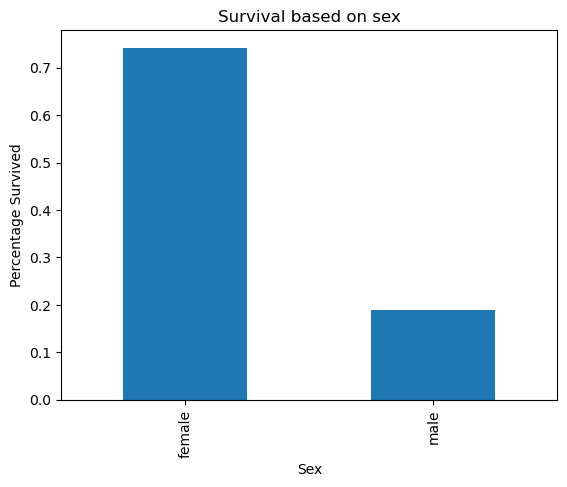

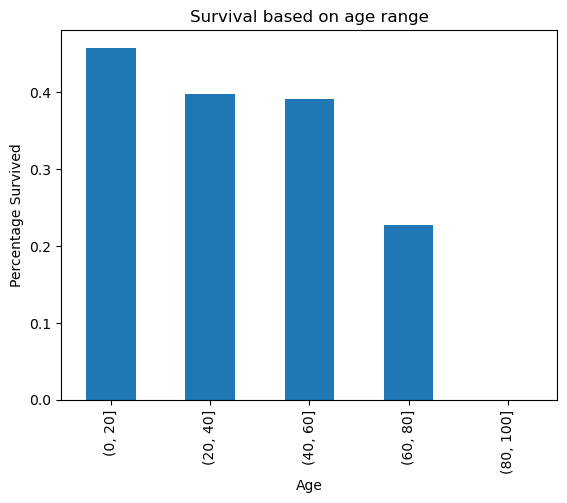

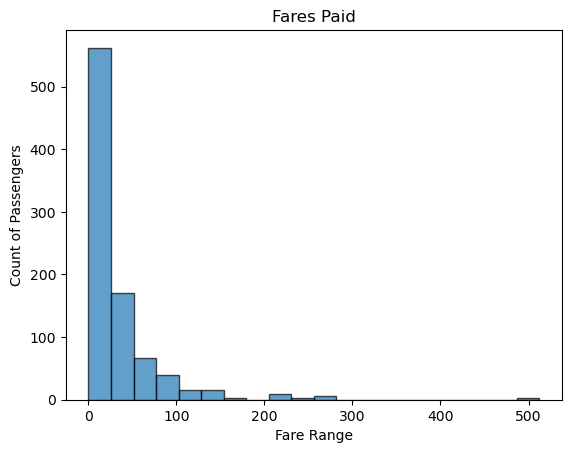

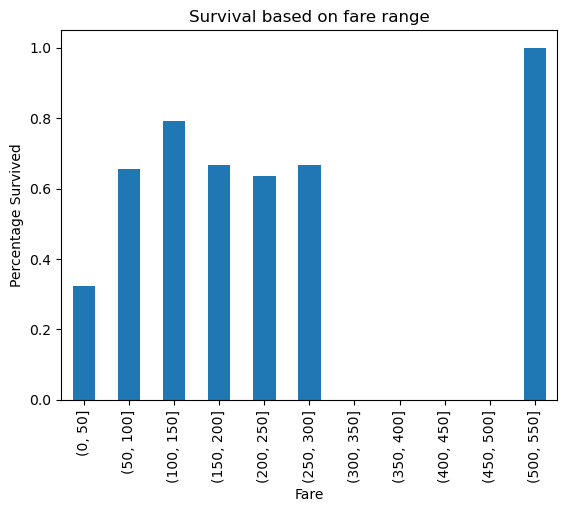

In [68]:
train_data.groupby('Sex').Survived.mean().plot(kind='bar')
plt.title("Survival based on sex")
plt.xlabel("Sex")
plt.ylabel("Percentage Survived")
plt.show()

# Define bins for value ranges
agebins = [0, 20, 40, 60, 80, 100]
train_data['age_bin'] = pd.cut(train_data['Age'], bins=agebins, right=True)

train_data.groupby('age_bin', observed=False).Survived.mean().plot(kind='bar')
plt.title("Survival based on age range")
plt.xlabel("Age")
plt.ylabel("Percentage Survived")
plt.show()

plt.hist(train_data['Fare'], bins=20, edgecolor='black', alpha=0.7)
plt.title("Fares Paid")
plt.xlabel("Fare Range")
plt.ylabel("Count of Passengers")
plt.show()

farebins = range(0, 600, 50)
train_data['fare_bin'] = pd.cut(train_data['Fare'], bins=farebins, right=True)

train_data.groupby('fare_bin', observed=False).Survived.mean().plot(kind='bar')
plt.title("Survival based on fare range")
plt.xlabel("Fare")
plt.ylabel("Percentage Survived")
plt.show()


## Building the first model

So this tells us that there is definitely a relationship with each of the values here.  After the homework exercises seemed to suggest that decision trees are a good starting point, lets start with those.  Originally I thought about using a RandomForestClassifier, but our dataset is fairly simple, and its not very large.

We will start with the following columns:

* age
* sex
* fare paid

and see how accurate that will be

My original version of this was doing dropna() so that we'd get rid of any numbers that were NA values.  That won't work because our testing data has NAs in it.  Lets fill in those as well.  For now, lets just use zeros.

In [69]:
# OK, lets convert our dataset to make sure we have numbers for everything - sex right now isn't a number.
# We'll need to do this smae processing on our submission data later, so lets make a method
def process_data(df):
    df = df.copy();
    df['sex_int'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Age'] = df['Age'].fillna(0);
    df['Fare'] = df['Fare'].fillna(0);
    return df

train_data_processed = process_data(train_data)

y = train_data_processed.dropna()['Survived']
X = train_data_processed.dropna().drop('Survived', axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(144, 14)

Lets build an SVC model based on the columns we want to try

In [70]:
from sklearn.tree import DecisionTreeClassifier

columns = ['sex_int', 'Fare', 'Age']

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train[columns], y_train)

DecisionTreeClassifier()

In [71]:
# Lets see how we did
score = decision_tree.score(X_test[columns], y_test)
print(score)

0.7567567567567568


Now lets run our testing data through the same thing and create a prediction file

In [72]:
test_file = pd.read_csv("test.csv")
#print(test_file)

test_data = process_data(test_file)
answers = decision_tree.predict(test_data[columns])

final_data = pd.DataFrame()
final_data['PassengerId'] = test_data['PassengerId']
final_data['Survived'] = answers

final_data.to_csv('decisiontree_output1.csv', index=False)

## Model Results

Ok.  So that model - against our segmented test data did ok (~70%).  But against the data in the competition did significantly worse (56%).  I'd like to try some things things:

* Change our model - maybe use an SVM
* Check our hyper-parameters on the model
* Add some more fields to the training set (Maybe working with Class of Service, And # of family members (both parents and children/spouses))
* If we can't figure anything else out, maybe we can change the way we predict the missing age data - since that seems to have a pretty big impact based on our exploration - maybe there are a ton of zeroes in the test data?


In [73]:
# So lets try a bunch of SVMs - we'll try all the kernels to see which is best.
# Lets play with some hyperparameters, and the same data
from sklearn.svm import SVC

for kernel in ["linear", "poly", "rbf", "sigmoid" ] :
    svm_kernel = SVC(kernel=kernel)
    svm_kernel.fit(X_train[columns], y_train)
    score = svm_kernel.score(X_test[columns], y_test)
    print(kernel + " Kernel Score: ", score)

linear Kernel Score:  0.7567567567567568
poly Kernel Score:  0.5405405405405406
rbf Kernel Score:  0.5405405405405406
sigmoid Kernel Score:  0.5405405405405406


Ok, using the same columns for predictions as a decision tree, our svm seems to give slightly better performance (75% vs 70%) with the linear kernel.

So at least for the kernel, our guess at using a linear kernel seems to be right with the other default hyperparameters.  The other main hyperparameter seems to be C

In [74]:
for c in [ 1.0, 5.0, 10.0, 50.0, 100.0 ] :
    svm_c = SVC(kernel='linear', C=c)
    svm_c.fit(X_train[columns], y_train)
    score = svm_c.score(X_test[columns], y_test)
    print(c, " C score: ", score)

1.0  C score:  0.7567567567567568
5.0  C score:  0.7567567567567568
10.0  C score:  0.7567567567567568
50.0  C score:  0.7567567567567568
100.0  C score:  0.7567567567567568


OK.  So that didn't seem to make any difference at all.  Lets move onto changing our data

In [75]:
columns2 = ['sex_int', 'Fare', 'Age', 'SibSp', 'Parch']
svm_model2 = SVC(kernel='linear', C=1.0)
svm_model2.fit(X_train[columns2], y_train)
score = svm_model2.score(X_test[columns2], y_test)
print("Added columns, score = ", score)


Added columns, score =  0.7297297297297297


So that is really interesting - we have actually made the model worse by adding those fields.  What if we also add Pclass

In [76]:
columns2 = ['sex_int', 'Fare', 'Age', 'SibSp', 'Parch', 'Pclass']
svm_model2 = SVC(kernel='linear', C=1.0)
svm_model2.fit(X_train[columns2], y_train)
score = svm_model2.score(X_test[columns2], y_test)
print("Added columns, score = ", score)


Added columns, score =  0.7567567567567568


Ok, back to ~75%.  Maybe we have some other fields that are making things worse... can we check to see which fields are useful and which aren't?

In [77]:
for i in range(0,6):
    cols=columns2.copy()
    dropped = cols[i]
    del cols[i]
    svm_model2 = SVC(kernel='linear', C=1.0)
    svm_model2.fit(X_train[cols], y_train)
    score = svm_model2.score(X_test[cols], y_test)
    print("Dropped Col = ", dropped, ", score = ", score)
    

Dropped Col =  sex_int , score =  0.5405405405405406
Dropped Col =  Fare , score =  0.7567567567567568
Dropped Col =  Age , score =  0.7567567567567568
Dropped Col =  SibSp , score =  0.7567567567567568
Dropped Col =  Parch , score =  0.7297297297297297
Dropped Col =  Pclass , score =  0.7297297297297297


Seems like the most important columns are sex, Parch and Pclass, what happens if we just use those?

In [78]:
columns3 = ['sex_int', 'Parch', 'Pclass']
svm_model3 = SVC(kernel='linear', C=1.0)
svm_model3.fit(X_train[columns3], y_train)
score = svm_model3.score(X_test[columns3], y_test)
print("Only 3 columns, score = ", score)


Only 3 columns, score =  0.7567567567567568


## Fililng in the missing data

Seems really strange that age doesn't seem predictive - especially given what we saw in the original data.  Right now we're just setting age to zero if we don't know it.  What if we set it to the mean of age, or if we try and predict the age from the other values - seems like the number of siblings/parents might have some value here.  While we are at it, set the fare to mean as well.

In [79]:
# OK, lets convert our dataset to make sure we have numbers for everything - sex right now isn't a number.
# We'll need to do this smae processing on our submission data later, so lets make a method
def process_data_mean(df):
    df = df.copy();
    df['sex_int'] = df['Sex'].map({'male': 0, 'female': 1})
    df['Age'] = df['Age'].fillna(df['Age'].mean());
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean());
    return df
    
train_data_processed = process_data_mean(train_data)
y = train_data_processed.dropna()['Survived']
X = train_data_processed.dropna().drop('Survived', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape


(144, 14)

In [80]:
columns4 = ['sex_int', 'Parch', 'Pclass', 'Age']
svm_model4 = SVC(kernel='linear', C=1.0)
svm_model4.fit(X_train[columns4], y_train)
score = svm_model4.score(X_test[columns4], y_test)
print("Age set to mean, score = ", score)


Age set to mean, score =  0.7297297297297297


OK, now that is promising.  Moving the needle a little bit.  What about Fare?

In [81]:
columns5 = ['sex_int', 'Parch', 'Pclass', 'Fare']
svm_model5 = SVC(kernel='linear', C=1.0)
svm_model5.fit(X_train[columns5], y_train)
score = svm_model5.score(X_test[columns5], y_test)
print("Fare set to mean, score = ", score)


Fare set to mean, score =  0.7567567567567568


Now with both?

In [82]:
columns6 = ['sex_int', 'Parch', 'Pclass', 'Fare', 'Age']
svm_model6 = SVC(kernel='linear', C=1.0)
svm_model6.fit(X_train[columns6], y_train)
score = svm_model6.score(X_test[columns6], y_test)
print("Age and Fare set to mean, score = ", score)


Age and Fare set to mean, score =  0.7567567567567568


Well, lets see if that helps at all with our scoring in the other test data

In [83]:
test_file = pd.read_csv("test.csv")

test_data = process_data(test_file)
answers = svm_model6.predict(test_data[columns6])

final_data = pd.DataFrame()
final_data['PassengerId'] = test_data['PassengerId']
final_data['Survived'] = answers

final_data.to_csv('model6_output.csv', index=False)

Ok.  Last try - lets use the new updated data and columns and see if a decision tree would do better (and maybe our SVM isn't the right model):

In [84]:
columns7 = ['sex_int', 'Parch', 'Pclass', 'Fare', 'Age']
decision_tree7 = DecisionTreeClassifier()
decision_tree7.fit(X_train[columns7], y_train)
score = decision_tree7.score(X_test[columns7], y_test)
print("Decision Tree with update columns = ", score)

test_file = pd.read_csv("test.csv")

test_data = process_data(test_file)
answers = decision_tree7.predict(test_data[columns7])

final_data = pd.DataFrame()
final_data['PassengerId'] = test_data['PassengerId']
final_data['Survived'] = answers

final_data.to_csv('model7_output.csv', index=False)

Decision Tree with update columns =  0.7027027027027027


Score doesn't seem great, lets see our submission... Only 54%, so we're defintiely doing better with the SVM.  Going to call it here.